In [32]:
%load_ext autoreload
%autoreload 2

In [95]:
import virtual_plan_diffusion
import torch, json, PIL.Image, transformers

input_folder = "control_labels/trajectories/003_grab_water_bottle_by_side"
with open(input_folder + "/data.json", "r") as f:
  trajectory = json.load(f)

"""
>>> print(trajectory.keys())

dict_keys([
  'times',
  'poses',
  'quaternions',
  'gripper_widths',
  'gripper_fully_closed_width',
  'gripper_fully_open_width'
])
"""

image = PIL.Image.open("control_labels/instructions/003_grab_water_bottle_by_side_start_position_left.png")

# For now, let's ignore quaternions... those are annoying :(
# Instead, let's just predict position.
# We'll also ignore gripper width for now.
# Put trajectory into a tensor.
# {x, y, z}: [0, 1, 2]
# {euler angles [3]}: [3, 4, 5]
# {gripper state}: [6]
trajectory_tensor = torch.zeros((len(trajectory["poses"]), 7))
trajectory_tensor[:, [0, 1, 2]] = torch.tensor(trajectory["poses"])
trajectory_tensor[:, 6] = torch.tensor(trajectory["gripper_widths"])
trajectory_tensor = trajectory_tensor[::4]

clip_vision_model: transformers.CLIPVisionModel = transformers.CLIPVisionModel.from_pretrained("openai/clip-vit-base-patch32") # type: ignore
clip_processor = transformers.CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

model = virtual_plan_diffusion.NoiseConditionedScoreModel(
  clip_vision_model,
  clip_processor,
  diffusion_betas=torch.linspace(0.001, 0.5, 10),
  max_trajectory_length=32,
  d_model=128,
  num_backbone_heads=8,
  num_backbone_layers=2
)
model.load_state_dict(torch.load("model.pt"))


Some weights of the model checkpoint at openai/clip-vit-base-patch32 were not used when initializing CLIPVisionModel: ['text_model.encoder.layers.8.mlp.fc2.bias', 'text_model.encoder.layers.10.self_attn.q_proj.weight', 'text_model.encoder.layers.11.layer_norm2.weight', 'text_model.encoder.layers.6.self_attn.out_proj.weight', 'text_model.encoder.layers.8.layer_norm1.weight', 'text_model.encoder.layers.3.self_attn.out_proj.weight', 'text_model.encoder.layers.1.self_attn.out_proj.weight', 'text_model.encoder.layers.6.mlp.fc2.bias', 'text_model.encoder.layers.3.self_attn.q_proj.bias', 'text_model.encoder.layers.11.layer_norm1.weight', 'text_model.encoder.layers.5.self_attn.v_proj.weight', 'text_model.encoder.layers.10.mlp.fc1.weight', 'text_model.encoder.layers.2.layer_norm1.bias', 'text_model.encoder.layers.2.mlp.fc2.bias', 'text_model.encoder.layers.10.self_attn.v_proj.weight', 'text_model.encoder.layers.7.self_attn.out_proj.bias', 'text_model.encoder.layers.6.self_attn.q_proj.weight', '

<All keys matched successfully>

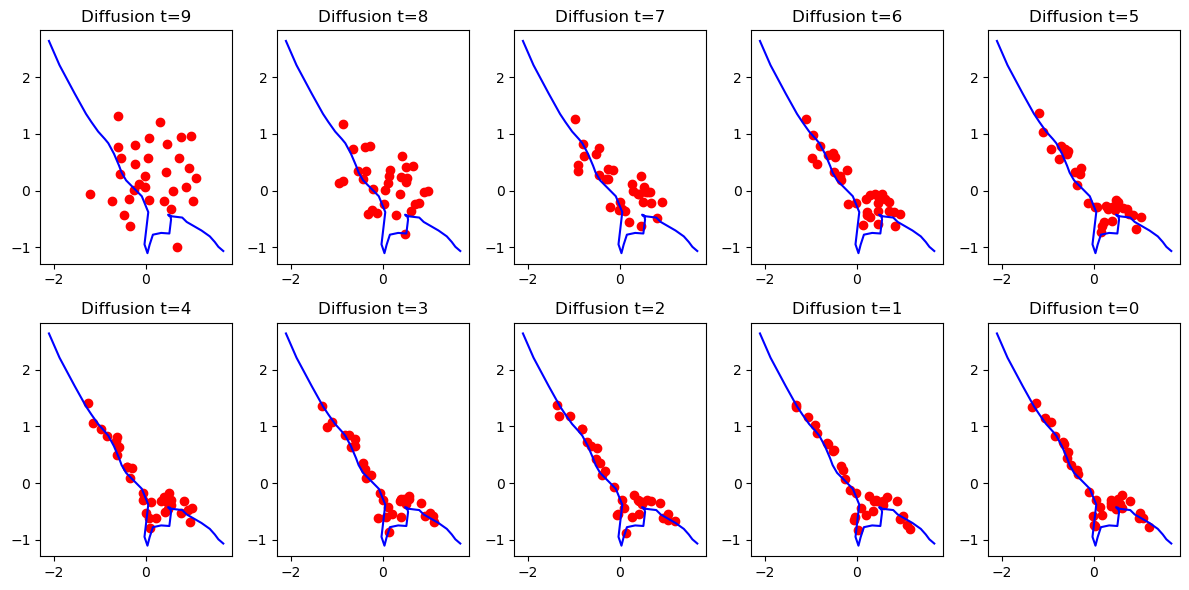

In [109]:
from matplotlib import pyplot as plt
import torch
import PIL.Image

image = PIL.Image.open("control_labels/instructions/003_grab_water_bottle_by_side_start_position_left.png")
sampled_trajectories = torch.load('sampled_trajectory.pt')
true_trajectory = torch.load('true_trajectory.pt')

sampled_trajectories = model.sample([image])

plt.rcParams['figure.figsize'] = (12, 6)

num_diffusion_steps = len(sampled_trajectories)
for i in range(1, len(sampled_trajectories)):
    plt.subplot(2, 5, i)
    trajectory = sampled_trajectories[i][0].detach().numpy()
    
    start_index = 100
    true_trajectory_segment = true_trajectory[start_index:start_index + 32].detach().numpy()
    true_trajectory_segment -= true_trajectory_segment.mean(0)
    true_trajectory_segment /= true_trajectory_segment.std(0)

    # Plot trajectory
    plt.title("Diffusion t=" + str(10 - i))
    plt.scatter(trajectory[:, 0], trajectory[:, 1], c='r')
    plt.plot(true_trajectory_segment[:, 0], true_trajectory_segment[:, 1], c='b')
plt.tight_layout()
plt.show()